# Task 4: User Satisfaction

In [2]:
!pip install mlflow


  Obtaining dependency information for mlflow from https://files.pythonhosted.org/packages/ce/2b/fd258716f219b22890bcbfe829bc6a2ecac56acf5e473bf236d27ee54c8a/mlflow-2.16.0-py3-none-any.whl.metadata
  Obtaining dependency information for mlflow-skinny==2.16.0 from https://files.pythonhosted.org/packages/2b/13/95c8ead52e2ec19b8130868b39bd6d72fa26b4321a0bb47cdc0ff9be6d06/mlflow_skinny-2.16.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic!=1.10.0,<2 from https://files.pythonhosted.org/packages/df/ed/c884465c33c25451e4a5cd4acad154c29e5341e3214e220e7f3478aa4b0d/alembic-1.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for docker<8,>=4.0.0 from https://files.pythonhosted.org/packages/e3/26/57c6fb270950d476074c087527a558ccb6f4436657314bfb6cdf484114c4/docker-7.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for graphene<4 from https://files.pythonhosted.org/packages/24/70/96f6027cdfc9bb89fc07627b615cb43fb1c443c93498412beaeaf157e9f1/gr

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\DELL\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\DELL\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\anaconda3\Lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\anaconda3\Lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\anaconda3\Lib\http\client.py", line 466, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "C:\Users\DELL\anaconda3\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^

In [1]:
import os
import sys

# path of the module files
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import *
from load_db import load_data_from_postgres, export_data_to_postgres


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

ModuleNotFoundError: No module named 'mlflow'

In [44]:
# read the CSV files from the other tasks
engagement = pd.read_csv("engagement.csv")
experience = pd.read_csv("experience.csv")

In [45]:
print(engagement.shape)
engagement.info()

(106857, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   MSISDN/Number              106856 non-null  float64
 1   Total Volume               106857 non-null  float64
 2   number_of_session          106857 non-null  float64
 3   Dur. (ms)                  106857 non-null  float64
 4   engagement_classification  106857 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.1 MB


In [46]:
print(experience.shape)
experience.info()

(59819, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59819 entries, 0 to 59818
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MSISDN/Number              59819 non-null  float64
 1   Handset Type               59819 non-null  object 
 2   Dur. (ms)                  59819 non-null  float64
 3   Avg RTT DL/UL              59819 non-null  float64
 4   Avg Bearer TP DL/UL        59819 non-null  float64
 5   TCP DL/UL                  59819 non-null  float64
 6   experience_classification  59819 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 3.2+ MB


## Task 4.1

In [47]:
# merge the two files using the users number
user_satisfaction = engagement.merge(experience, on =['MSISDN/Number','Dur. (ms)'])   

In [48]:
# information on the dataframe
print(user_satisfaction.shape)
user_satisfaction.info()

(38971, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38971 entries, 0 to 38970
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MSISDN/Number              38971 non-null  float64
 1   Total Volume               38971 non-null  float64
 2   number_of_session          38971 non-null  float64
 3   Dur. (ms)                  38971 non-null  float64
 4   engagement_classification  38971 non-null  int64  
 5   Handset Type               38971 non-null  object 
 6   Avg RTT DL/UL              38971 non-null  float64
 7   Avg Bearer TP DL/UL        38971 non-null  float64
 8   TCP DL/UL                  38971 non-null  float64
 9   experience_classification  38971 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 3.0+ MB


In [49]:
# drop the engagement_classification and experience classification to calculate K-mean cluster again
user_satisfaction.drop(columns = ['engagement_classification','experience_classification'],inplace = True)

In [50]:
# k-means cluster and scores of user statisfaction
engagement_metric = ['Total Volume','number_of_session','Dur. (ms)']
experience_metric = ['Avg RTT DL/UL','Avg Bearer TP DL/UL','TCP DL/UL']

scaler = StandardScaler()
engagement_scaled = scaler.fit_transform(user_satisfaction[engagement_metric])
experience_scaled = scaler.fit_transform(user_satisfaction[experience_metric])

# Group the users into three clusters
kmeans_engaged = KMeans(n_clusters=3, random_state=42)
kmeans_experience = KMeans(n_clusters=3, random_state=42)

kmeans_engaged.fit(engagement_scaled)
kmeans_experience.fit(experience_scaled)

# find the centroid of each clusters
engagement_centroid = kmeans_engaged.cluster_centers_
experience_centroid = kmeans_experience.cluster_centers_

# least engaged is with the lowest average 'Dur. (ms)' value
least_engaged_cluster = np.argmin(engagement_centroid[:,2])
least_engaged_centroid = engagement_centroid[least_engaged_cluster]


# worst experience is with the highest 'Avg RTT DL/UL' value
worst_experience_cluster = np.argmax(experience_centroid[:,0])
worst_experience_centroid = experience_centroid[worst_experience_cluster]


# computing euclidean distance and assign score
user_satisfaction['engagement_score'] = np.linalg.norm(engagement_scaled - least_engaged_centroid, axis = 1)
user_satisfaction['experience_score'] = np.linalg.norm(experience_scaled - worst_experience_centroid, axis = 1)

In [51]:
# focusing on the satisfaction metrics
user_satisfaction = user_satisfaction[['MSISDN/Number','engagement_score','experience_score']]

In [52]:
user_satisfaction['MSISDN/Number'] = user_satisfaction['MSISDN/Number'].astype(str)

## Task 4.2

In [53]:
# adding statisfaction score as the the average of engagement score the experience score
user_satisfaction['satisfaction_score'] = (user_satisfaction['engagement_score'] + user_satisfaction['experience_score']) / 2

In [54]:
user_satisfaction.head()

,MSISDN/Number,engagement_score,experience_score,satisfaction_score
0,33601001722.0,0.812154,20.133863,10.473009
1,33601001754.0,2.792994,20.190739,11.491867
2,33601022743.0,0.936224,20.126585,10.531404
3,33601024291.0,3.121696,20.145855,11.633775
4,33601025738.0,2.426446,20.120070,11.273258


In [55]:
# Top 10 statisfied customers
user_satisfaction[['MSISDN/Number','satisfaction_score']].sort_values(by = 'satisfaction_score',ascending = False).head(10)

,MSISDN/Number,satisfaction_score
18850,33662947066.0,20.100867
753,33607212604.0,19.771871
6247,33628716098.0,19.313778
1854,33611587488.0,19.240717
17885,33662269701.0,18.871658
12968,33658820950.0,17.788429
35203,33761905065.0,17.721779
37367,33771945898.0,16.578553
11593,33652557319.0,15.419600
20444,33664109705.0,15.172783


## Task 4.3

## Linear Regression

In [56]:
# split the target and feature of the user statisfaction dataset
X = user_satisfaction[['engagement_score','experience_score']]   # features
y = user_satisfaction['satisfaction_score']                      # target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split to test and train sets
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# the linear model
model = LinearRegression()
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

print(f"The Mean Squared Error of the model {mean_squared_error(y_test, y_hat)}")
print(f"The R-Squared value: {r2_score(y_test, y_hat)}")

# Perform cross-validation (e.g., 5-fold)
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean of the cross-validation scores
print(f"Cross-Validation MSE: {-cross_val_scores.mean()}")

The Mean Squared Error of the model 8.72807040035743e-31
The R-Squared value: 1.0
Cross-Validation MSE: 2.744250115994903e-30


- The model fit the data perfectly.
- MSE close to 0: The model has made almost no error in predictions. The predicted values are extremely close to the actual values.
- R-squared value of 1.0: This means the model explains all the variance in the target variable perfectly.

> Build the model using Ridge to eliminate if their is overfitting

In [57]:
# Define Ridge regression model
ridge = Ridge()

# Define a range of alpha values
alpha_values = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search with cross-validation to find the best alpha
grid_search = GridSearchCV(ridge, param_grid=alpha_values, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Print the best alpha value and corresponding score
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_

print(f"Best alpha value: {best_alpha}")
print(f"Cross-Validation MSE with best alpha: {best_score}")

Best alpha value: 0.001
Cross-Validation MSE with best alpha: 4.918015015119972e-16


## Task 4.4

In [58]:
# users engagement classififcation using k-means
columns = ['engagement_score','experience_score']
for col in columns:
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(np.array(user_satisfaction[col]).reshape(-1,1))

    kmeans = KMeans(n_clusters = 2, random_state = 42)
    user_satisfaction[col + '_cluster'] = kmeans.fit_predict(normalized_data)


In [59]:
user_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38971 entries, 0 to 38970
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MSISDN/Number             38971 non-null  object 
 1   engagement_score          38971 non-null  float64
 2   experience_score          38971 non-null  float64
 3   satisfaction_score        38971 non-null  float64
 4   engagement_score_cluster  38971 non-null  int32  
 5   experience_score_cluster  38971 non-null  int32  
dtypes: float64(3), int32(2), object(1)
memory usage: 1.5+ MB


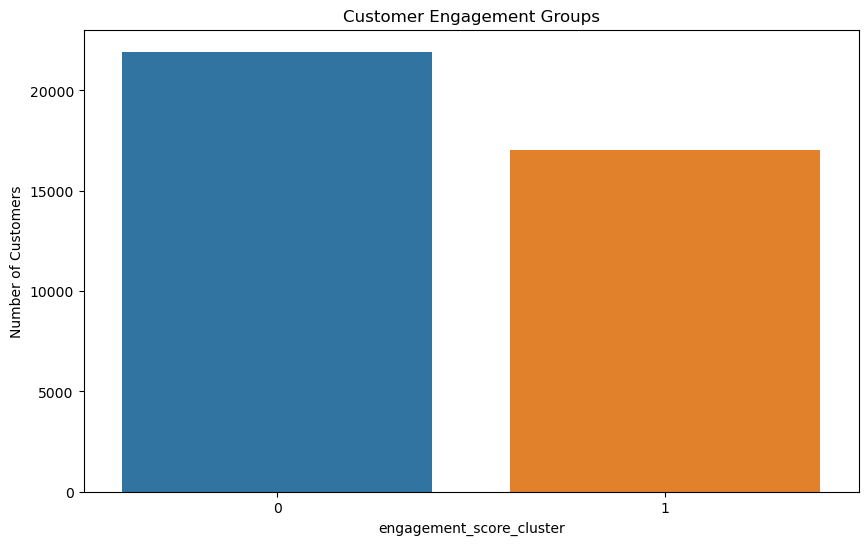

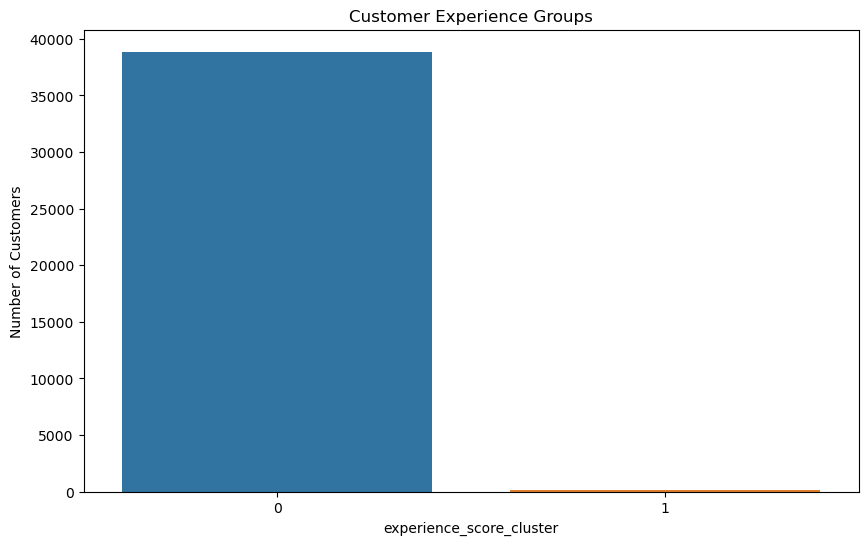

In [60]:
columns = ['engagement_score_cluster','experience_score_cluster']
title = ['Engagement', 'Experience']
# plot the number of engagements
for i,col in enumerate(columns):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=user_satisfaction)
    plt.title('Customer ' + title[i] + ' Groups')
    plt.xlabel(col)
    plt.ylabel('Number of Customers')
    plt.show()

## Task 4.5

In [61]:
# Aggregate the average satisfaction & experience score per engagement_score_cluster
user_satisfaction.groupby('engagement_score_cluster')[['satisfaction_score','engagement_score','experience_score']].mean().reset_index()

,engagement_score_cluster,satisfaction_score,engagement_score,experience_score
0,0,10.545030,0.967944,20.122117
1,1,11.212562,2.316226,20.108897


In [62]:
# from sqlalchemy import create_engine, text
# # Define your connection details
# username = 'postgres'
# password = '1089elda'
# host = 'localhost'  # or your PostgreSQL host
# port = 5432  # default PostgreSQL port
# dbname = 'telecom'

# # Create SQLAlchemy engine
# engine = create_engine(f'postgresql+psycopg2://{username}:{password}@{host}:{port}/{dbname}')

# # Export the DataFrame to PostgreSQL
# try:
#     # Assuming user_satisfaction is your DataFrame
#     user_satisfaction.to_sql('user_satisfaction', con=engine, if_exists='replace', index=False)

#     # Verify the data by executing a query
#     query = text("SELECT * FROM user_satisfaction")
#     with engine.connect() as conn:
#         result = conn.execute(query)

#         # Convert the result to a Pandas DataFrame
#         df = pd.DataFrame(result.fetchall(), columns=result.keys())
#         print(df.head())  # Display the first few rows of the DataFrame

# except Exception as e:
#     print(f"An error occurred: {e}")


## Task 4.6

In [65]:
# exporting the dataframe to Postgres
export_data_to_postgres(user_satisfaction)

   MSISDN/Number  engagement_score  experience_score  satisfaction_score  \
0  33601001722.0          0.812154         20.133863           10.473009   
1  33601001754.0          2.792994         20.190739           11.491867   
2  33601022743.0          0.936224         20.126585           10.531404   
3  33601024291.0          3.121696         20.145855           11.633775   
4  33601025738.0          2.426446         20.120070           11.273258   

   engagement_score_cluster  experience_score_cluster  
0                         0                         0  
1                         1                         0  
2                         0                         0  
3                         1                         0  
4                         1                         0  


## Task 4.7

In [66]:
with mlflow.start_run():
    # split the target and feature of the user statisfaction dataset
    X = user_satisfaction[['engagement_score','experience_score']]   # features
    y = user_satisfaction['satisfaction_score']                      # target

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # split to test and train sets
    X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

    # define Ridge regression model
    alpha_values = 0.001
    ridge = Ridge(alpha=0.001)
    ridge.fit(X_train,y_train)

    # record parameter
    mlflow.log_param('alpha',alpha_values)

    # Predict on the test set
    y_hat = ridge.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    mlflow.log_metrics("MSE",mse)

    r2 = r2_score(y_test, y_hat)
    mlflow.log_metrics("R2_Score",mse)

    # log the model
    mlflow.sklearn.log_model(ridge, "Ridge_Model")

    


NameError: name 'mlflow' is not defined

In [ ]:



# Perform grid search with cross-validation to find the best alpha
grid_search = GridSearchCV(ridge, param_grid=alpha_values, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Print the best alpha value and corresponding score
best_alpha = grid_search.best_params_['alpha']
best_score = -grid_search.best_score_

print(f"Best alpha value: {best_alpha}")
print(f"Cross-Validation MSE with best alpha: {best_score}")

In [ ]:


# the linear model
model = LinearRegression()
model.fit(X_train, y_train)

y_hat = model.predict(X_test)

print(f"The Mean Squared Error of the model {mean_squared_error(y_test, y_hat)}")
print(f"The R-Squared value: {r2_score(y_test, y_hat)}")

# Perform cross-validation (e.g., 5-fold)
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean of the cross-validation scores
print(f"Cross-Validation MSE: {-cross_val_scores.mean()}")